###Problem on CART-RF-ANN:
####An Insurance firm providing tour insurance is facing higher claim frequency. The management decides to collect data from the past few years. You are assigned the task to make a model which predicts the claim status and provide recommendations to management. Use CART, RF & ANN and compare the models' performances in train and test sets.

In [ ]:
#IMPORTING NECESSARY LIBRARIES

# for Colab access
import os
from google.colab import drive
drive.mount ('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks')

# Basic computations, visualiations and supressing warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings("ignore")

#Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import time

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Libraries for Model Evaluation 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import auc, roc_auc_score, roc_curve

Mounted at /content/drive


### **1. Data Ingestion: Read the dataset. Do the descriptive statistics and do null value condition check, write an inference on it.**


In [ ]:
data = pd.read_csv("insurance data.csv")
data.head()

Age Agency_Code           Type  ...  Sales       Product Name Destination
0   48         C2B       Airlines  ...   2.51    Customised Plan        ASIA
1   36         EPX  Travel Agency  ...  20.00    Customised Plan        ASIA
2   39         CWT  Travel Agency  ...   9.90    Customised Plan    Americas
3   36         EPX  Travel Agency  ...  26.00  Cancellation Plan        ASIA
4   33         JZI       Airlines  ...  18.00        Bronze Plan        ASIA

[5 rows x 10 columns]

In [ ]:
# Fix the spelling of the column
data = data.rename(columns={'Commision': 'Commission'})

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           3000 non-null   int64  
 1   Agency_Code   3000 non-null   object 
 2   Type          3000 non-null   object 
 3   Claimed       3000 non-null   object 
 4   Commission    3000 non-null   float64
 5   Channel       3000 non-null   object 
 6   Duration      3000 non-null   int64  
 7   Sales         3000 non-null   float64
 8   Product Name  3000 non-null   object 
 9   Destination   3000 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 234.5+ KB


In [ ]:
data.describe()

Age   Commission     Duration        Sales
count  3000.000000  3000.000000  3000.000000  3000.000000
mean     38.091000    14.529203    70.001333    60.249913
std      10.463518    25.481455   134.053313    70.733954
min       8.000000     0.000000    -1.000000     0.000000
25%      32.000000     0.000000    11.000000    20.000000
50%      36.000000     4.630000    26.500000    33.000000
75%      42.000000    17.235000    63.000000    69.000000
max      84.000000   210.210000  4580.000000   539.000000

In [ ]:
data.describe(include='object')

Agency_Code           Type Claimed Channel     Product Name Destination
count         3000           3000    3000    3000             3000        3000
unique           4              2       2       2                5           3
top            EPX  Travel Agency      No  Online  Customised Plan        ASIA
freq          1365           1837    2076    2954             1136        2465

In [ ]:
# Purging the dataset of duplicates
print("Total no. of duplicates found", len(data)-len(data.drop_duplicates()))
data = data.drop_duplicates(keep='first')
data.describe(include = 'all')

Total no. of duplicates found 139


Age Agency_Code  ...     Product Name Destination
count   2861.000000        2861  ...             2861        2861
unique          NaN           4  ...                5           3
top             NaN         EPX  ...  Customised Plan        ASIA
freq            NaN        1238  ...             1071        2327
mean      38.204124         NaN  ...              NaN         NaN
std       10.678106         NaN  ...              NaN         NaN
min        8.000000         NaN  ...              NaN         NaN
25%       31.000000         NaN  ...              NaN         NaN
50%       36.000000         NaN  ...              NaN         NaN
75%       43.000000         NaN  ...              NaN         NaN
max       84.000000         NaN  ...              NaN         NaN

[11 rows x 10 columns]

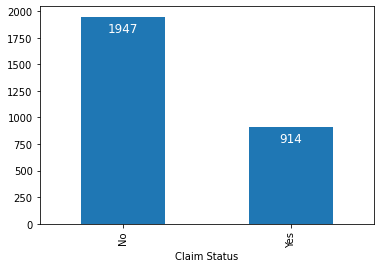

In [ ]:
x = data.Claimed.value_counts().plot.bar()
for p in x.patches:
    x.annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, -12),
                   textcoords = 'offset points', color = 'white', fontsize=12)
plt.xlabel("Claim Status")
plt.show()
# The data is imbalanced, so we will not use accuracy as the measureto evalute the model.

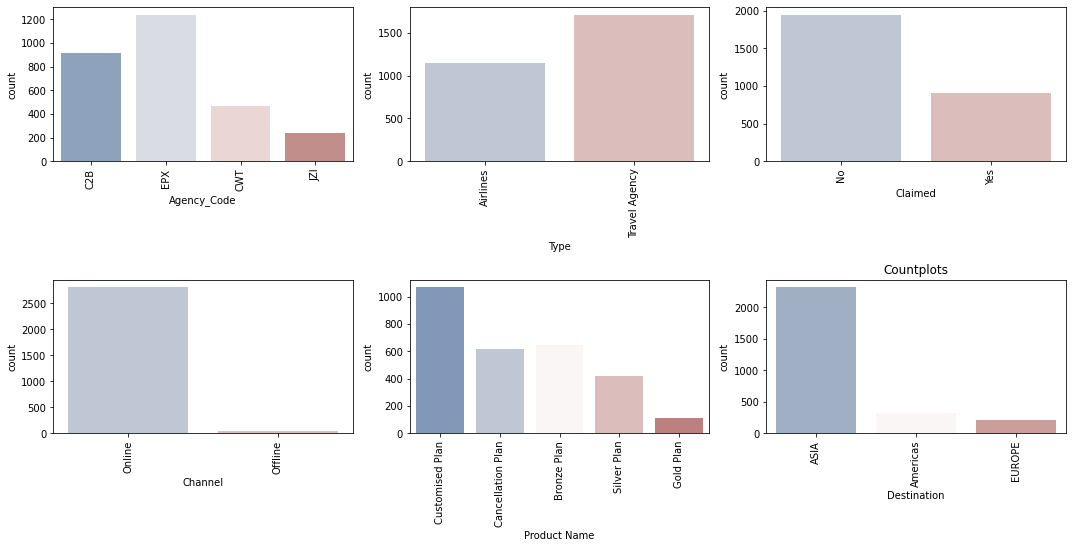

In [ ]:
#Separate the Categorical data for EDA
datacat = data[['Agency_Code', 'Type',	'Claimed', 'Channel',	'Product Name',	'Destination']]
fig=plt.figure(figsize=(15,10))

#Present the value counts of Categorical features as Countpolt
for i in range(0,len(datacat.columns)):
    ax=fig.add_subplot(3,3,i+1)
    sns.countplot(datacat[datacat.columns[i]], palette = "vlag")
    #ax.set_title(datacat.columns[i],color='Blue')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Countplots')
plt.tight_layout()
plt.show()

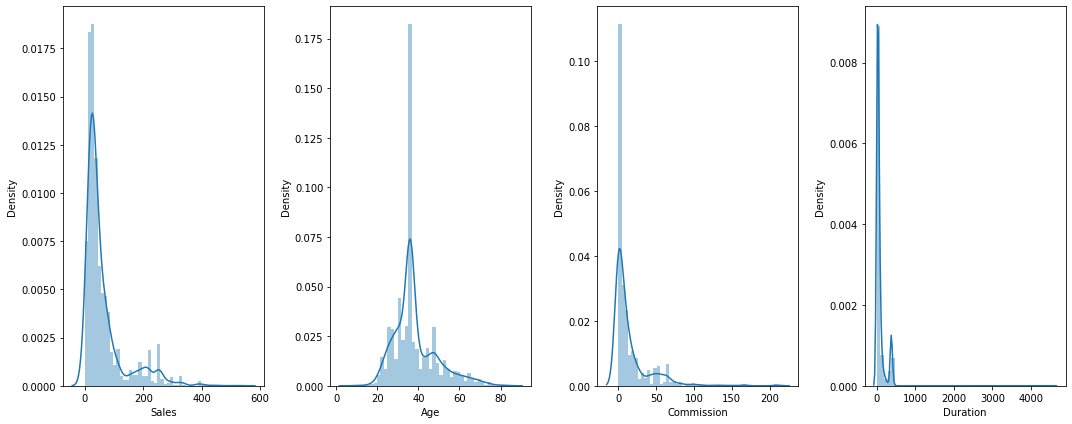

In [ ]:
#Separate the Categorical data for EDA
datanum = data[['Sales', 'Age','Commission', 'Duration']]
fig=plt.figure(figsize=(15,6))

#Present the value counts of Categorical features as Countpolt
for i in range(0,len(datanum.columns)):
    ax=fig.add_subplot(1,4,i+1)
    sns.distplot(datanum[datanum.columns[i]])
    #ax.set_title(datanum.columns[i],color='Blue')
plt.tight_layout()
plt.show()

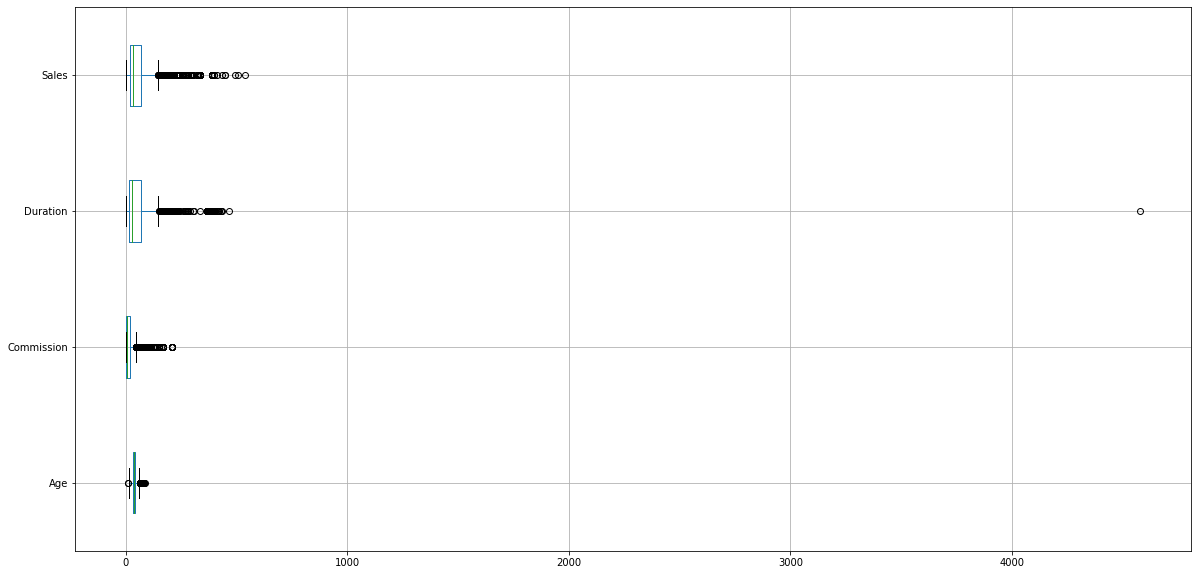

In [ ]:
plt.figure(figsize=(20,10))
data[['Age', 'Commission',	'Duration',	'Sales']].boxplot(vert=0)
plt.show()

In [ ]:
# Treat 2 extreme Outliers in Duration
# First one is Duration of 4580
data.loc[data['Duration'] == 4580]
#Calculating the mean Duration of similar data
d2 = data[(data['Claimed'] == 0) & (data['Agency_Code'] == 0) & (data['Type'] == 0) & (data['Channel'] == 1) & (data['Product Name'] == 2) 
& (data['Destination'] == 0)]

d2.drop(d2[d2['Duration'] == 4580].index, inplace = True) 
d2.loc[d2['Duration'] == 4580]
d2.describe()
#Imputing the specific datapoint
data["Duration"] = np.where((data["Duration"] == 4580), 70.4, data["Duration"])

In [ ]:
# Second one is Duration of -1
data.loc[data['Duration'] == -1]
#Calculating the mean Duration of similar data
d3 = data[(data['Claimed'] == 0) & (data['Agency_Code'] == 3) & (data['Type'] == 0) & (data['Channel'] == 1) & (data['Product Name'] == 0) 
& (data['Destination'] == 0)]

d3.drop(d3[d3['Duration'] == -1].index, inplace = True) 
#Imputing the specific datapoint
data["Duration"] = np.where((data["Duration"] == -1), 40.2, data["Duration"])

# Extreme outliers havebeen treated
data.describe()

Age   Commission     Duration        Sales
count  2861.000000  2861.000000  2861.000000  2861.000000
mean     38.204124    15.080996    70.558406    61.757878
std      10.678106    25.826834   106.679936    71.399740
min       8.000000     0.000000     0.000000     0.000000
25%      31.000000     0.000000    12.000000    20.000000
50%      36.000000     5.630000    28.000000    33.500000
75%      43.000000    17.820000    66.000000    69.300000
max      84.000000   210.210000   466.000000   539.000000

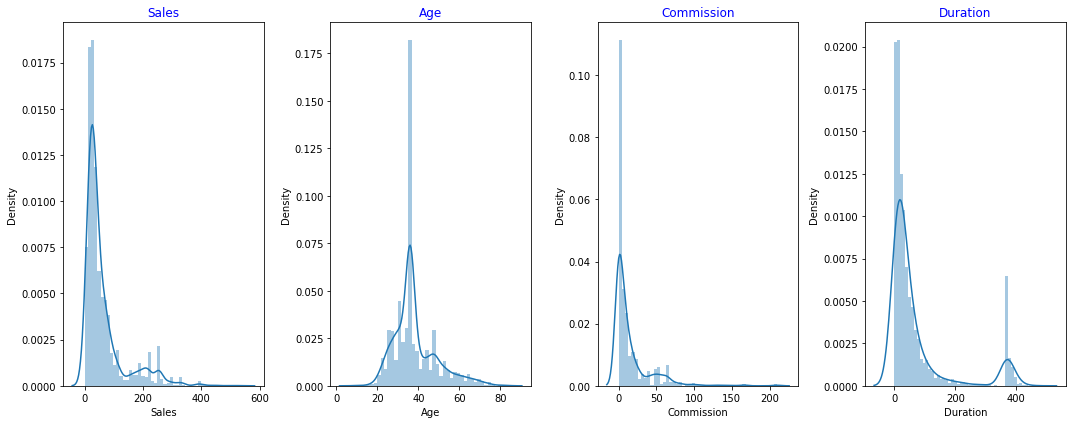

In [ ]:
datanum1 = data[['Sales', 'Age','Commission', 'Duration']]
fig=plt.figure(figsize=(15,6))

#Present the value counts of Categorical features as Countpolt
for i in range(0,len(datanum1.columns)):
    ax=fig.add_subplot(1,4,i+1)
    sns.distplot(datanum1[datanum1.columns[i]])
    ax.set_title(datanum1.columns[i],color='Blue')
plt.tight_layout()
plt.show()

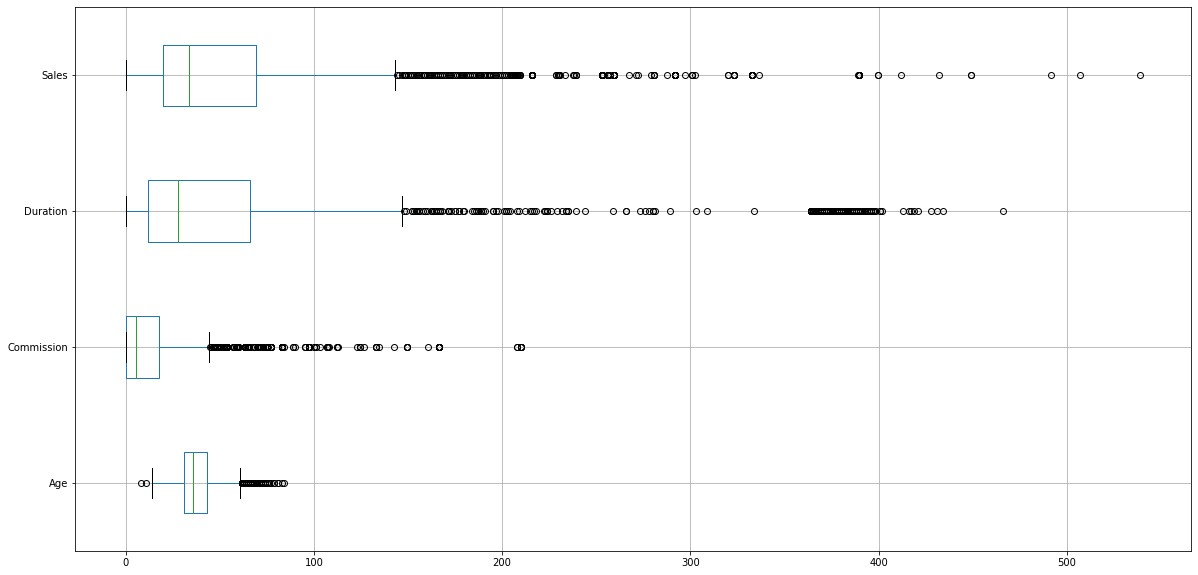

In [ ]:
# Assessing the extent of outliers
plt.figure(figsize=(20,10))
data[['Age', 'Commission',	'Duration',	'Sales']].boxplot(vert=0)
plt.show()

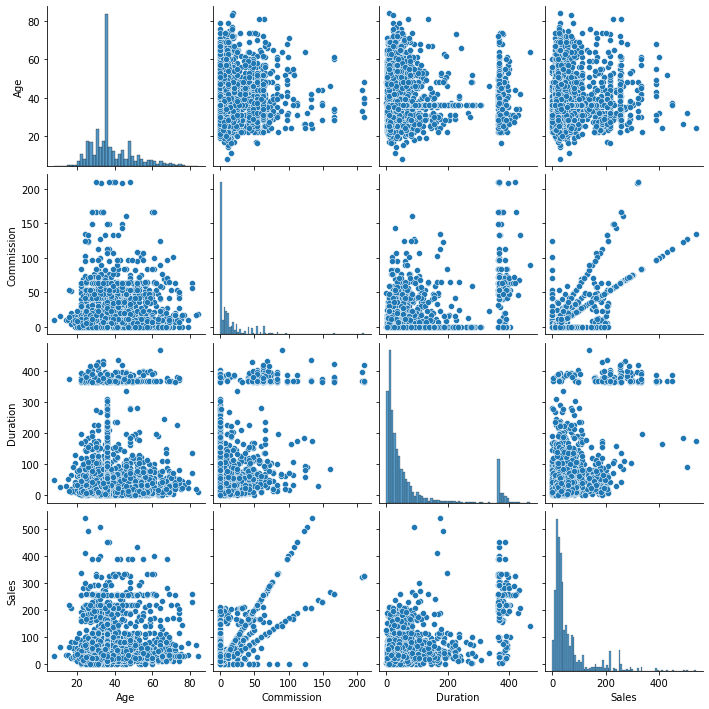

In [ ]:
# Show Pairplot to show possible correlation between numerical variables
sns.pairplot(data)
plt.show()

In [ ]:
# There appears to be some correlation between Sales and Commission, as expected. 

In [ ]:
# Encode objects data with Categorical codes
for i in data.columns:
  if data[i].dtype == 'object':
    data[i] = pd.Categorical(data[i]).codes

# Check whether the encodign has been done
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2861 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           2861 non-null   int64  
 1   Agency_Code   2861 non-null   int8   
 2   Type          2861 non-null   int8   
 3   Claimed       2861 non-null   int8   
 4   Commission    2861 non-null   float64
 5   Channel       2861 non-null   int8   
 6   Duration      2861 non-null   float64
 7   Sales         2861 non-null   float64
 8   Product Name  2861 non-null   int8   
 9   Destination   2861 non-null   int8   
dtypes: float64(3), int64(1), int8(6)
memory usage: 208.5 KB



### **2. Data Split: Split the data into test(30% of the data) and train(70% of the data), build classification model CART, Random Forest, Artificial Neural Network**


### **3) Performance Metrics: Check the performance of Predictions on Train and Test sets using Accuracy, Confusion Matrix, Plot ROC curve and get ROC_AUC score for each model**

Both questions attempted below:

In [ ]:
# Separating the Independent and target variables
df_predictors = data.drop('Claimed', axis = 1)
df_target = data['Claimed']

In [ ]:
# Spliting the data in train and test
X_train, X_test, y_train, y_test = train_test_split(df_predictors, df_target, test_size = 0.3, random_state = 123)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2002, 9)
(2002,)
(859, 9)
(859,)


### Decision Tree (CART) Model

In [ ]:
#Declare the CART model 
dtcl = DecisionTreeClassifier(criterion = 'gini', random_state = 12)
#Fit the data to the model
model1 = dtcl.fit(X_train, y_train)

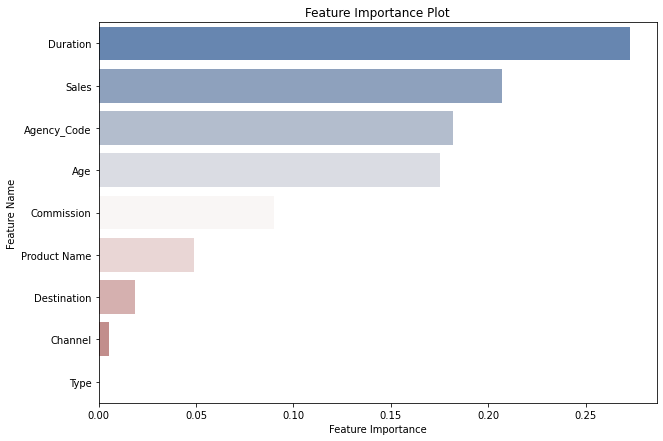

In [ ]:
#Feature importances according the the CART model
model1.feature_importances_
# See Feature Importance visually
model1_a = pd.DataFrame(model1.feature_importances_, columns = ["Importance"], index = df_predictors.columns).sort_values("Importance", ascending = False)
plt.figure(figsize=(10,7))
sns.barplot(x = model1_a.Importance, y = model1_a.index, palette='vlag')
plt.ylabel('Feature Name')
plt.xlabel('Feature Importance')
plt.title('Feature Importance Plot')
plt.show()

In [ ]:
#Construct the tree
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus

tree_viz = export_graphviz(model1, feature_names = df_predictors.columns, class_names = ['0','1'])
tree_plot = pydotplus.graph_from_dot_data(tree_viz)

#Display the Decision Tree
Image(tree_plot.create_png())

In [ ]:
# Make class predictions
dt_ytrain_pred = model1.predict(X_train)
dt_ytest_pred = model1.predict(X_test)

# Make probability predictions
dt_ytrain_pred_prob = model1.predict_proba(X_train)
dt_ytest_pred_prob = model1.predict_proba(X_test)

##### Decision Tree - Train

In [ ]:
# Performance Scores - Train
CART_train_AS = accuracy_score(y_train, dt_ytrain_pred, normalize = True)*100
CART_train_PS = precision_score(y_train, dt_ytrain_pred)*100
CART_train_F1 = f1_score(y_train, dt_ytrain_pred)*100
CART_train_RS = recall_score(y_train, dt_ytrain_pred)*100

print('The Train CART Accuracy Score is %.2f'%CART_train_AS,'%')
print('The Train CART Precision Score is %.2f'%CART_train_PS,'%')
print('The Train CART F1 Score is %.2f'%CART_train_F1,'%')
print('The Train CART Recall Score is %.2f'%CART_train_RS,'%')

The Train CART Accuracy Score is 99.25 %
The Train CART Precision Score is 100.00 %
The Train CART F1 Score is 98.83 %
The Train CART Recall Score is 97.68 %


[[1356    0]
 [  15  631]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1356
           1       1.00      0.98      0.99       646

    accuracy                           0.99      2002
   macro avg       0.99      0.99      0.99      2002
weighted avg       0.99      0.99      0.99      2002



________________________________________________________________




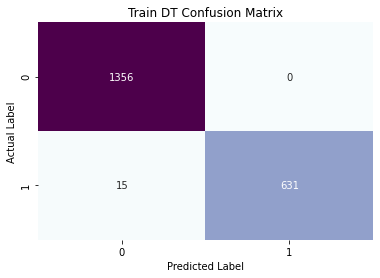

In [ ]:
# Confusion Report and Classification Matrix
print(confusion_matrix(y_train, dt_ytrain_pred))
print(classification_report(y_train, dt_ytrain_pred))
print('\n')
print("________________________________________________________________")
print('\n')
sns.heatmap(confusion_matrix(y_train, dt_ytrain_pred),annot=True, fmt='d', cbar=False,cmap='BuPu')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Train DT Confusion Matrix')
plt.show()

Train DT AUC 1.00


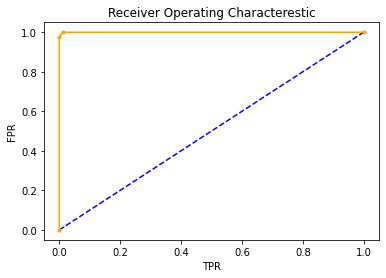

In [ ]:
#AUC - ROC for model Performance (Train)
#AUC
dt_train_auc = roc_auc_score(y_train, dt_ytrain_pred_prob[:,1])
print("Train DT AUC %.2f" % dt_train_auc)
#ROC
fpr_dt_tr, tpr_dt_tr, th_dt = roc_curve(y_train, dt_ytrain_pred_prob[:,1], pos_label= 1)
plt.plot ([0,1],[0,1], linestyle = '--', color = 'blue', label = 'Unskilled')
plt.plot(fpr_dt_tr, tpr_dt_tr, marker = '.', color = 'orange', label = 'Skill')
plt.ylabel('FPR')
plt.xlabel('TPR')
plt.title('Receiver Operating Characterestic')
plt.show()

##### Decision Tree - Test

In [ ]:
# Performance Scores - Test
CART_test_AS = accuracy_score(y_test, dt_ytest_pred, normalize = True)*100
CART_test_PS = precision_score(y_test, dt_ytest_pred)*100
CART_test_F1 = f1_score(y_test, dt_ytest_pred)*100
CART_test_RS = recall_score(y_test, dt_ytest_pred)*100

print('The Test CART Accuracy Score is %.2f'%CART_test_AS,'%')
print('The Test CART Precision Score is %.2f'%CART_test_PS,'%')
print('The Test CART F1 Score is %.2f'%CART_test_F1,'%')
print('The Test CART Recall Score is %.2f'%CART_test_RS,'%')

The Test CART Accuracy Score is 69.62 %
The Test CART Precision Score is 51.29 %
The Test CART F1 Score is 51.58 %
The Test CART Recall Score is 51.87 %


[[459 132]
 [129 139]]
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       591
           1       0.51      0.52      0.52       268

    accuracy                           0.70       859
   macro avg       0.65      0.65      0.65       859
weighted avg       0.70      0.70      0.70       859



________________________________________________________________




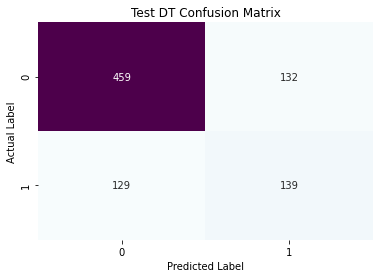

In [ ]:
# Confusion Report and Classification Matrix (Test)
print(confusion_matrix(y_test, dt_ytest_pred))
print(classification_report(y_test, dt_ytest_pred))
print('\n')
print("________________________________________________________________")
print('\n')
sns.heatmap(confusion_matrix(y_test, dt_ytest_pred),annot=True, fmt='d', cbar=False,cmap='BuPu')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Test DT Confusion Matrix')
plt.show()

Test DT AUC 0.65


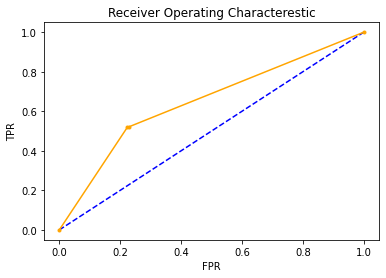

In [ ]:
#AUC - ROC for model Performance (Test)
dt_test_auc = roc_auc_score(y_test, dt_ytest_pred_prob[:,1])
print("Test DT AUC %.2f" % dt_test_auc)
#ROC
fpr_dt_t, tpr_dt_t, th_dt_t = roc_curve(y_test, dt_ytest_pred_prob[:,1], pos_label= 1)
plt.plot ([0,1],[0,1], linestyle = '--', color = 'blue', label = 'Unskilled')
plt.plot(fpr_dt_t, tpr_dt_t, marker = '.', color = 'orange', label = 'Skill')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('Receiver Operating Characterestic')
plt.show()

In [ ]:
# Highly over fit model

### Decision Tree (CART) - GridSearch

In [ ]:
dtcl1 = DecisionTreeClassifier()

#Lets set the grid of hyperparameters
param_grid ={'criterion':['gini', 'entropy'],
            'max_depth':range(4, 9),
            'min_samples_split':[90, 100, 120],
            'min_samples_leaf': [30, 35, 40, 50]}
dtgrid = GridSearchCV(estimator = dtcl1, param_grid = param_grid, cv = 10, verbose = 1)
dtgrid.fit(X_train, y_train)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:    7.4s finished


GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                  

In [ ]:
##Identify the best hyperparameters assessed by GridSearch
dtgrid.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'min_samples_leaf': 30,
 'min_samples_split': 90}

In [ ]:
# Build the model using the best parameters and fit the data
dtgrid1 = DecisionTreeClassifier(criterion = dtgrid.best_params_.get('criterion'), random_state = 12, 
                                 max_depth = dtgrid.best_params_.get('max_depth'), min_samples_leaf = dtgrid.best_params_.get('min_samples_leaf'), 
                                 min_samples_split = dtgrid.best_params_.get('min_samples_split'))
dtgrid2 = dtgrid1.fit(X_train, y_train)

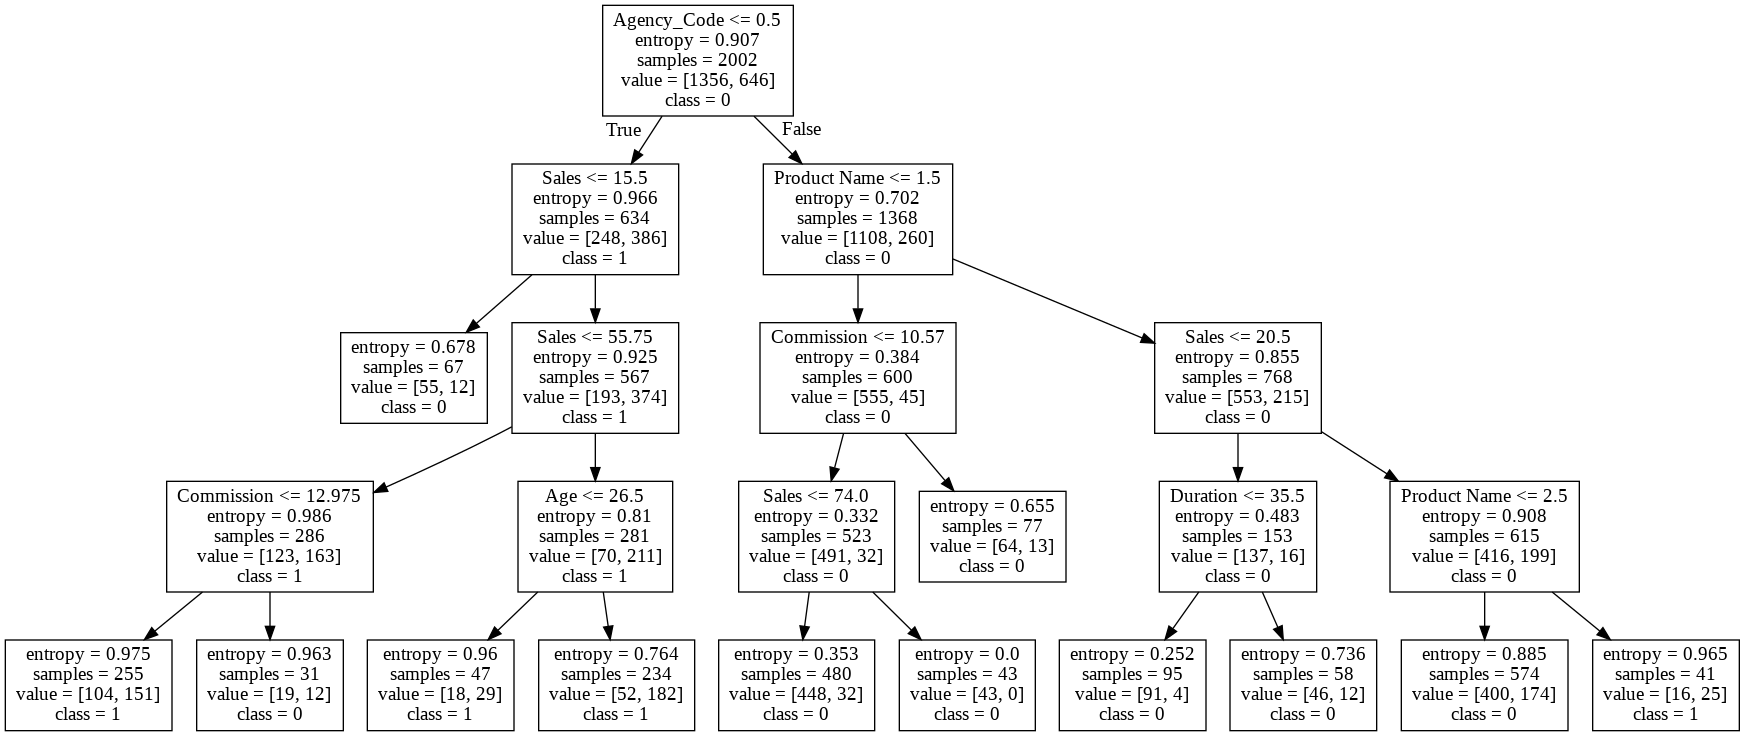

In [ ]:
#Construct the tree

tree_viz_gs = export_graphviz(dtgrid2, feature_names = df_predictors.columns, class_names = ['0','1'])

tree_plot = pydotplus.graph_from_dot_data(tree_viz_gs)

#Display the Decision Tree
Image(tree_plot.create_png())

In [ ]:
# Make class predictions based on the model
dtgs_ytrain_pred = dtgrid2.predict(X_train)
dtgs_ytest_pred = dtgrid2.predict(X_test)

# Make probability predictions
dtgs_ytrain_pred_prob = dtgrid2.predict_proba(X_train)
dtgs_ytest_pred_prob = dtgrid2.predict_proba(X_test)

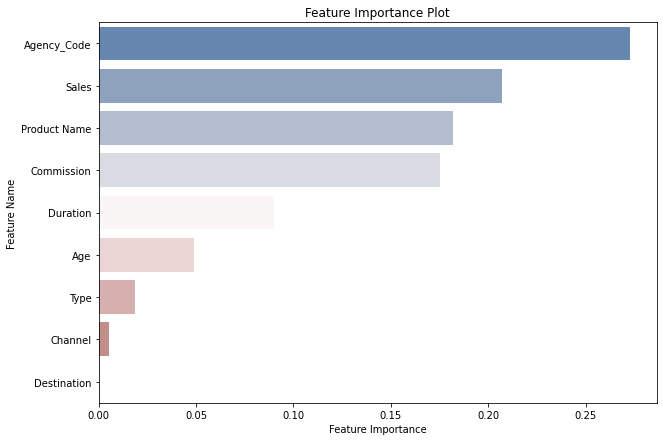

In [ ]:
#Feature importances according the CART model
dtgrid2.feature_importances_
# See Feature Importance visially
dtgrid2_a = pd.DataFrame(dtgrid2.feature_importances_, columns = ["Importance"], index = df_predictors.columns).sort_values("Importance", ascending = False)
plt.figure(figsize=(10,7))
sns.barplot(x = model1_a.Importance, y = dtgrid2_a.index, palette='vlag')
plt.ylabel('Feature Name')
plt.xlabel('Feature Importance')
plt.title('Feature Importance Plot')
plt.show()

##### Decision Tree GridSearch - Train

In [ ]:
# Performance Scores
DTGS_train_AS = accuracy_score(y_train, dtgs_ytrain_pred, normalize = True)*100
DTGS_train_PS = precision_score(y_train, dtgs_ytrain_pred)*100
DTGS_train_F1 = f1_score(y_train, dtgs_ytrain_pred)*100
DTGS_train_RS = recall_score(y_train, dtgs_ytrain_pred)*100

print('The Train DTGS Accuracy Score is %.2f'%DTGS_train_AS,'%')
print('The Train DTGS Precision Score is %.2f'%DTGS_train_PS,'%')
print('The Train DTGS F1 Score is %.2f'%DTGS_train_F1,'%')
print('The Train DTGS Recall Score is %.2f'%DTGS_train_RS,'%')

The Train DTGS Accuracy Score is 77.57 %
The Train DTGS Precision Score is 67.07 %
The Train DTGS F1 Score is 63.29 %
The Train DTGS Recall Score is 59.91 %


[[1166  190]
 [ 259  387]]
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1356
           1       0.67      0.60      0.63       646

    accuracy                           0.78      2002
   macro avg       0.74      0.73      0.74      2002
weighted avg       0.77      0.78      0.77      2002



________________________________________________________________




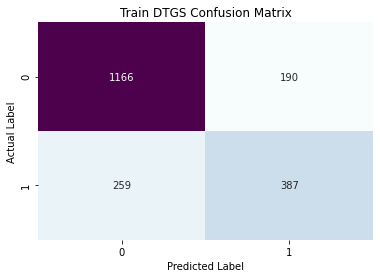

In [ ]:
# Confusion Report and Classification Matrix
print(confusion_matrix(y_train, dtgs_ytrain_pred))
print(classification_report(y_train, dtgs_ytrain_pred))
print('\n')
print("________________________________________________________________")
print('\n')
sns.heatmap(confusion_matrix(y_train, dtgs_ytrain_pred),annot=True, fmt='d', cbar=False,cmap='BuPu')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Train DTGS Confusion Matrix')
plt.show()

Train DTGS AUC 0.81


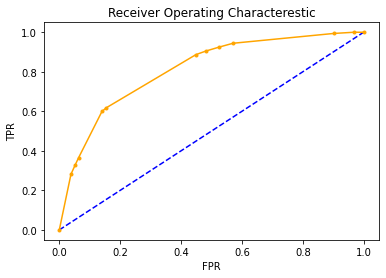

In [ ]:
#AUC - ROC for model performance (Train)

#AUC

dtgs_train_auc = roc_auc_score(y_train, dtgs_ytrain_pred_prob[:,1])
print("Train DTGS AUC %.2f" % dtgs_train_auc)

#ROC
fpr_dtgs_tr, tpr_dtgs_tr, th_dtgs_tr = roc_curve(y_train, dtgs_ytrain_pred_prob[:,1], pos_label= 1)
plt.plot ([0,1],[0,1], linestyle = '--', color = 'blue', label = 'Unskilled')
plt.plot(fpr_dtgs_tr, tpr_dtgs_tr, marker = '.', color = 'orange', label = 'Skill')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('Receiver Operating Characterestic')
plt.show()

In [ ]:

# Performance Scores

from sklearn.metrics import fbeta_score
DTGS_test_AS = accuracy_score(y_test, dtgs_ytest_pred, normalize = True)*100
DTGS_test_PS = precision_score(y_test, dtgs_ytest_pred)*100
DTGS_test_F1 = f1_score(y_test, dtgs_ytest_pred)*100
DTGS_test_RS = recall_score(y_test, dtgs_ytest_pred)*100
DTGS_test_fBeta = fbeta_score(y_test, dtgs_ytest_pred, beta=2.0)*100

print('Test DTGS Accuracy Score is %.2f'%DTGS_test_AS,'%')
print('Test DTGS Precision Score is %.2f'%DTGS_test_PS,'%')
print('Test DTGS F1 Score is %.2f'%DTGS_test_F1,'%')
print('Test DTGS Recall Score is %.2f'%DTGS_test_RS,'%')
print('Test DTGS fBeta Score is %.2f'%DTGS_test_fBeta,'%')

Test DTGS Accuracy Score is 78.11 %
Test DTGS Precision Score is 65.50 %
Test DTGS F1 Score is 64.26 %
Test DTGS Recall Score is 63.06 %
Test DTGS fBeta Score is 63.53 %


[[502  89]
 [ 99 169]]
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       591
           1       0.66      0.63      0.64       268

    accuracy                           0.78       859
   macro avg       0.75      0.74      0.74       859
weighted avg       0.78      0.78      0.78       859



________________________________________________________________




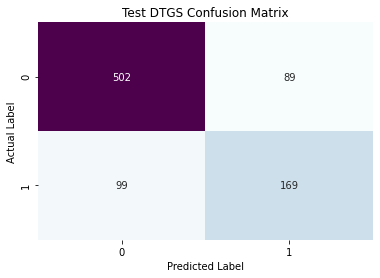

In [ ]:
# Confusion Report and Classification Matrix to check model performance
print(confusion_matrix(y_test, dtgs_ytest_pred))
print(classification_report(y_test, dtgs_ytest_pred))

print('\n')
print("________________________________________________________________")
print('\n')
sns.heatmap(confusion_matrix(y_test, dtgs_ytest_pred),annot=True, fmt='d', cbar=False,cmap='BuPu')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Test DTGS Confusion Matrix')
plt.show()

Test DTGS AUC 0.79


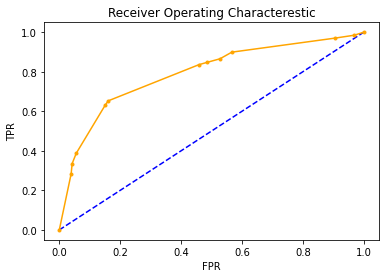

In [ ]:
#AUC - ROC for model performance (Test)

#AUC
dtgs_test_auc  = roc_auc_score(y_test, dtgs_ytest_pred_prob[:,1])
print("Test DTGS AUC %.2f" % dtgs_test_auc)

#ROC
fpr_dtgs_t, tpr_dtgs_t, th_dtgs_t = roc_curve(y_test, dtgs_ytest_pred_prob[:,1], pos_label= 1)
plt.plot ([0,1],[0,1], linestyle = '--', color = 'blue', label = 'Unskilled')
plt.plot(fpr_dtgs_t, tpr_dtgs_t, marker = '.', color = 'orange', label = 'Skill')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('Receiver Operating Characterestic')
plt.show()



### Random Forest

In [ ]:
# Build the model - Call the model, fill in the hyperparamenters
n=600
msl=30
mss=100
md=4
mf=7
criterion = 'gini'

rf_model= RandomForestClassifier(n_estimators=n, min_samples_leaf=msl, min_samples_split=mss, max_depth=md, criterion = 'gini', oob_score = True, max_features =mf, random_state = 123)

In [ ]:
# Fit the data, calculate the model building time 

start_time = time.time()
rf_model.fit(X_train, y_train)
print("The time taken is", (time.time() - start_time))

The time taken is 1.7526345252990723


In [ ]:
# Make class predictions with the best model
rf_ypred_train = rf_model.predict(X_train)
rf_ypred_test = rf_model.predict(X_test)


In [ ]:
rf_ypred_train_prob = rf_model.predict_proba(X_train)
rf_ypred_test_prob = rf_model.predict_proba(X_test)

##### Random Forest - Train

In [ ]:
# Performance Scores - Train 
RF_train_AS = accuracy_score(y_train, rf_ypred_train, normalize = True)*100
RF_train_PS = precision_score(y_train, rf_ypred_train)*100
RF_train_F1 = f1_score(y_train, rf_ypred_train)*100
RF_train_RS = recall_score(y_train, rf_ypred_train)*100

print('Train RF Accuracy Score is %.2f'%RF_train_AS,'%')
print('Train RF Precision Score is %.2f'%RF_train_PS,'%')
print('Train RF F1 Score is %.2f'%RF_train_F1,'%')
print('Train RF Recall Score is %.2f'%RF_train_RS,'%')

Train RF Accuracy Score is 77.07 %
Train RF Precision Score is 66.85 %
Train RF F1 Score is 61.78 %
Train RF Recall Score is 57.43 %


[[1172  184]
 [ 275  371]]
              precision    recall  f1-score   support

           0       0.81      0.86      0.84      1356
           1       0.67      0.57      0.62       646

    accuracy                           0.77      2002
   macro avg       0.74      0.72      0.73      2002
weighted avg       0.76      0.77      0.77      2002

      
______________________________________________________
           


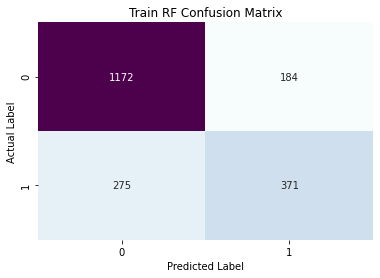

In [ ]:
# Confusion Report and Classification Matrix to check model performance
print(confusion_matrix(y_train, rf_ypred_train))
print(classification_report(y_train, rf_ypred_train))
print("      ")
print("______________________________________________________")

print("           ")
sns.heatmap(confusion_matrix(y_train, rf_ypred_train),annot=True, fmt='d', cbar=False,cmap='BuPu')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Train RF Confusion Matrix')
plt.show()

Train RF AUC 0.83


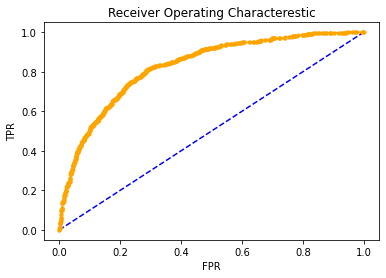

In [ ]:
#Random forest AUC (Train)
rf_train_auc = roc_auc_score(y_train, rf_ypred_train_prob[:,1])
print("Train RF AUC %.2f" % rf_train_auc)

#ROC
fpr_rf_tr, tpr_rf_tr, th_rf_tr = roc_curve(y_train, rf_ypred_train_prob[:,1], pos_label= 1)
plt.plot ([0,1],[0,1], linestyle = '--', color = 'blue', label = 'Unskilled')
plt.plot(fpr_rf_tr, tpr_rf_tr, marker = '.', color = 'orange', label = 'Skill')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('Receiver Operating Characterestic')
plt.show()

##### Random Forest - Test

In [ ]:
# Performance Scores - Train 
RF_test_AS = accuracy_score(y_test, rf_ypred_test, normalize = True)*100
RF_test_PS = precision_score(y_test, rf_ypred_test)*100
RF_test_F1 = f1_score(y_test, rf_ypred_test)*100
RF_test_RS = recall_score(y_test, rf_ypred_test)*100

print('Test RF Accuracy Score is %.2f'%RF_test_AS,'%')
print('Test RF Precision Score is %.2f'%RF_test_PS,'%')
print('Test RF F1 Score is %.2f'%RF_test_F1,'%')
print('Test RF Recall Score is %.2f'%RF_test_RS,'%')


Test RF Accuracy Score is 78.11 %
Test RF Precision Score is 66.39 %
Test RF F1 Score is 63.28 %
Test RF Recall Score is 60.45 %


              precision    recall  f1-score   support

           0       0.83      0.86      0.84       591
           1       0.66      0.60      0.63       268

    accuracy                           0.78       859
   macro avg       0.75      0.73      0.74       859
weighted avg       0.78      0.78      0.78       859

      
________________________________________________________
           


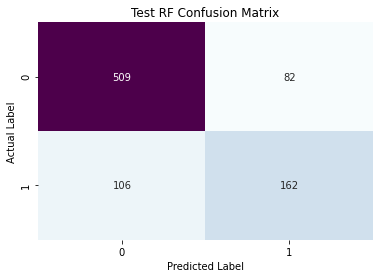

In [ ]:
# Confusion Report and Classification Matrix to check model performance
print(classification_report(y_test, rf_ypred_test))
print("      ")
print("________________________________________________________")

print("           ")
sns.heatmap(confusion_matrix(y_test, rf_ypred_test),annot=True, fmt='d', cbar=False,cmap='BuPu')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Test RF Confusion Matrix')
plt.show()



Test RF AUC 0.80


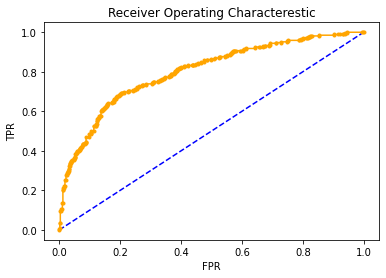

In [ ]:
#Random Forest AUC Test
rf_test_auc = roc_auc_score(y_test, rf_ypred_test_prob[:,1])
print("Test RF AUC %.2f" % rf_test_auc)

#RF ROC Test
fpr_rf_t, tpr_rf_t, th_rf_t = roc_curve(y_test, rf_ypred_test_prob[:,1], pos_label= 1)
plt.plot ([0,1],[0,1], linestyle = '--', color = 'blue', label = 'Unskilled')
plt.plot(fpr_rf_t, tpr_rf_t, marker = '.', color = 'orange', label = 'Skill')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('Receiver Operating Characterestic')
plt.show()

In [ ]:
# Compare with Out of Bag values and see model performance
rf_model.oob_score_

0.7597402597402597

#### Random Forest - GridSearch

In [ ]:
# Define parameters for the RF Grid Search
param_grid = {'n_estimators': [300,500],
              'max_depth': [5,7],
              'min_samples_split' : [90, 150],
              'min_samples_leaf':[30, 50],
              'max_features': [8,10],
              'criterion': ['gini', 'criterion']}

In [ ]:
# Call the model, define the hyperparamters 
rf_model1 = RandomForestClassifier(random_state = 123)
rfgrid = GridSearchCV(estimator = rf_model1, param_grid =param_grid, cv = 10)

In [ ]:
# Fit the model with train data, calculate the model making time 
start_time = time.time()
rfgrid.fit(X_train, y_train)
print('The time taken is', (time.time() - start_time))

The time taken is 240.3725724220276


In [ ]:
# Finding the best parameters
rfgrid.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'max_features': 8,
 'min_samples_leaf': 50,
 'min_samples_split': 90,
 'n_estimators': 300}

In [ ]:
# Finding the best model
rfbestgrid = rfgrid.best_estimator_

In [ ]:
# Make class predictions with the best model
rfgs_ypred_train = rfbestgrid.predict(X_train)
rfgs_ypred_test = rfbestgrid.predict(X_test)

# Make probability predictions with the best model
rfgs_ypred_train_prob = rfbestgrid.predict_proba(X_train)
rfgs_ypred_test_prob = rfbestgrid.predict_proba(X_test)

In [ ]:
# Check the class distribution.
pd.Series(rfgs_ypred_train).value_counts()

0    1473
1     529
dtype: int64

In [ ]:
pd.Series(rfgs_ypred_test).value_counts()

0    629
1    230
dtype: int64

##### Random Forest - GridSearch - Train

In [ ]:
# Performance Scores - Train 
RFGS_train_AS = accuracy_score(y_train, rfgs_ypred_train, normalize = True)*100
RFGS_train_PS = precision_score(y_train, rfgs_ypred_train)*100
RFGS_train_F1 = f1_score(y_train, rfgs_ypred_train)*100
RFGS_train_RS = recall_score(y_train, rfgs_ypred_train)*100

print('Train RFGS Accuracy Score is %.2f'%RFGS_train_AS,'%')
print('Train RFGS Precision Score is %.2f'%RFGS_train_PS,'%')
print('Train RFGS F1 Score is %.2f'%RFGS_train_F1,'%')
print('Train RFGS Recall Score is %.2f'%RFGS_train_RS,'%')

Train RFGS Accuracy Score is 77.17 %
Train RFGS Precision Score is 67.86 %
Train RFGS F1 Score is 61.11 %
Train RFGS Recall Score is 55.57 %


[[1186  170]
 [ 287  359]]
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1356
           1       0.68      0.56      0.61       646

    accuracy                           0.77      2002
   macro avg       0.74      0.72      0.72      2002
weighted avg       0.76      0.77      0.77      2002

      
______________________________________________________
           


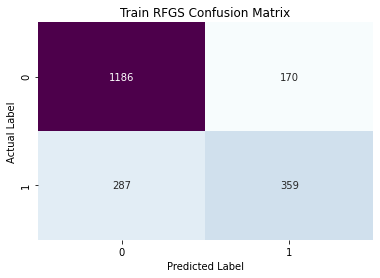

In [ ]:
# Confusion Report and Classification Matrix to check model performance
print(confusion_matrix(y_train, rfgs_ypred_train))
print(classification_report(y_train, rfgs_ypred_train))
print("      ")
print("______________________________________________________")

print("           ")
sns.heatmap(confusion_matrix(y_train, rfgs_ypred_train),annot=True, fmt='d', cbar=False,cmap='BuPu')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Train RFGS Confusion Matrix')
plt.show()

Train RFGS AUC 0.83


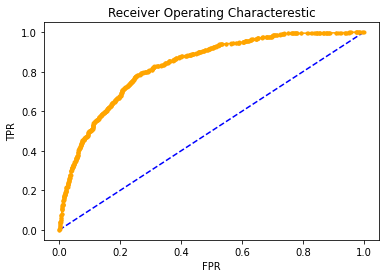

In [ ]:
#Random forest AUC (Train)
rfgs_train_auc = roc_auc_score(y_train, rfgs_ypred_train_prob[:,1])
print("Train RFGS AUC %.2f" % rfgs_train_auc)

#ROC
fpr_rfgs_tr, tpr_rfgs_tr, th_rfgs_tr = roc_curve(y_train, rfgs_ypred_train_prob[:,1], pos_label= 1)
plt.plot ([0,1],[0,1], linestyle = '--', color = 'blue', label = 'Unskilled')
plt.plot(fpr_rfgs_tr, tpr_rfgs_tr, marker = '.', color = 'orange', label = 'Skill')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('Receiver Operating Characterestic')
plt.show()

##### Random Forest - GridSearch - Test



In [ ]:
# Performance Scores - Train 
RFGS_test_AS = accuracy_score(y_test, rfgs_ypred_test, normalize = True)*100
RFGS_test_PS = precision_score(y_test, rfgs_ypred_test)*100
RFGS_test_F1 = f1_score(y_test, rfgs_ypred_test)*100
RFGS_test_RS = recall_score(y_test, rfgs_ypred_test)*100

print('Test RFGS Accuracy Score is %.2f'%RFGS_test_AS,'%')
print('Test RFGS Precision Score is %.2f'%RFGS_test_PS,'%')
print('Test RFGS F1 Score is %.2f'%RFGS_test_F1,'%')
print('Test RFGS Recall Score is %.2f'%RFGS_test_RS,'%')

Test RFGS Accuracy Score is 77.18 %
Test RFGS Precision Score is 65.65 %
Test RFGS F1 Score is 60.64 %
Test RFGS Recall Score is 56.34 %


              precision    recall  f1-score   support

           0       0.81      0.87      0.84       591
           1       0.66      0.56      0.61       268

    accuracy                           0.77       859
   macro avg       0.74      0.71      0.72       859
weighted avg       0.76      0.77      0.77       859

      
________________________________________________________
           


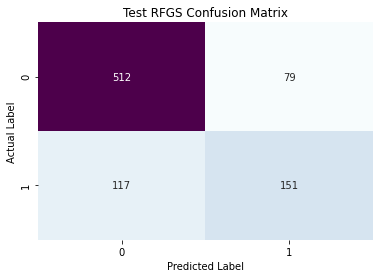

In [ ]:
# Confusion Report and Classification Matrix to check model performance
print(classification_report(y_test, rfgs_ypred_test))
print("      ")
print("________________________________________________________")

print("           ")
sns.heatmap(confusion_matrix(y_test, rfgs_ypred_test),annot=True, fmt='d', cbar=False,cmap='BuPu')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Test RFGS Confusion Matrix')
plt.show()

Test RF AUC 0.80


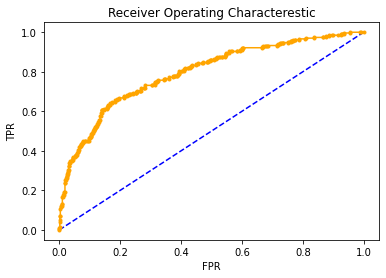

In [ ]:
#Random Forest Grid AUC Test
rfgs_test_auc = roc_auc_score(y_test, rfgs_ypred_test_prob[:,1])
print("Test RF AUC %.2f" % rfgs_test_auc)

#RF ROC Test

fpr_rfgs_t, tpr_rfgs_t, th_rfgs_t = roc_curve(y_test, rfgs_ypred_test_prob[:,1], pos_label= 1)
plt.plot ([0,1],[0,1], linestyle = '--', color = 'blue', label = 'Unskilled')
plt.plot(fpr_rfgs_t, tpr_rfgs_t, marker = '.', color = 'orange', label = 'Skill')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('Receiver Operating Characterestic')
plt.show()

#### Neural Network

In [ ]:
# Scaling
scaling = StandardScaler()
X_train = scaling.fit_transform(X_train)
X_test = scaling.transform(X_test)

# Separating the Independent and target variables
df_predictors = data.drop('Claimed', axis = 1)
df_target = data['Claimed']


X_train, X_test, y_train, y_test = train_test_split(df_predictors, df_target, test_size = 0.3, random_state = 123)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


# Define hyperparamters
MLP_model = MLPClassifier(hidden_layer_sizes= (20,30, 50),
                          max_iter = 100, 
                          activation = 'logistic',
                          solver = 'adam',
                          random_state= 567,
                          learning_rate = 'adaptive',
                          tol = 0.0001,
                          verbose = True)


(2002, 9)
(2002,)
(859, 9)
(859,)


In [ ]:
# Fit the Neural Network model with train data
MLP_model.fit(X_train, y_train)

Iteration 1, loss = 0.71448408
Iteration 2, loss = 0.64685499
Iteration 3, loss = 0.62925022
Iteration 4, loss = 0.62951933
Iteration 5, loss = 0.62892640
Iteration 6, loss = 0.62730387
Iteration 7, loss = 0.62688869
Iteration 8, loss = 0.62646339
Iteration 9, loss = 0.62584778
Iteration 10, loss = 0.62290604
Iteration 11, loss = 0.62136202
Iteration 12, loss = 0.61950178
Iteration 13, loss = 0.61736158
Iteration 14, loss = 0.61723069
Iteration 15, loss = 0.61831227
Iteration 16, loss = 0.61133565
Iteration 17, loss = 0.60742045
Iteration 18, loss = 0.60557587
Iteration 19, loss = 0.60246286
Iteration 20, loss = 0.60069325
Iteration 21, loss = 0.59835403
Iteration 22, loss = 0.59550678
Iteration 23, loss = 0.59442257
Iteration 24, loss = 0.59373674
Iteration 25, loss = 0.58906131
Iteration 26, loss = 0.58517169
Iteration 27, loss = 0.58292905
Iteration 28, loss = 0.58103990
Iteration 29, loss = 0.57787963
Iteration 30, loss = 0.57729802
Iteration 31, loss = 0.57652720
Iteration 32, los

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20, 30, 50), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=100,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=567, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=True,
              warm_start=False)

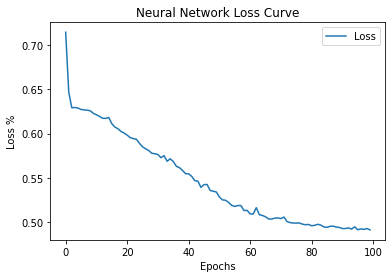

In [ ]:
# Plot the loss curve to see how the model is performing
loss_values = MLP_model.loss_curve_
plt.plot(loss_values, label = 'Loss')
plt.xlabel("Epochs")
plt.ylabel('Loss %')
plt.title("Neural Network Loss Curve")
plt.legend()
plt.show()

In [ ]:
# Make train and test class predictions based on the model
nn_ytrain_pred = MLP_model.predict(X_train)
nn_ytest_pred = MLP_model.predict(X_test)

# Make train and test probability predictions based on the model
nn_ytrain_pred_prob = MLP_model.predict_proba(X_train)
nn_ytest_pred_prob = MLP_model.predict_proba(X_test)


#####Neural Network - Train


In [ ]:
# Performance Scores - Train 
NN_train_AS = accuracy_score(y_train, nn_ytrain_pred, normalize = True)*100
NN_train_PS = precision_score(y_train, nn_ytrain_pred)*100
NN_train_F1 = f1_score(y_train, nn_ytrain_pred)*100
NN_train_RS = recall_score(y_train, nn_ytrain_pred)*100

print('The Train NN Accuracy Score is %.2f'%NN_train_AS,'%')
print('The Train NN Precision Score is %.2f'%NN_train_PS,'%')
print('The Train NN F1 Score is %.2f'%NN_train_F1,'%')
print('The Train NN Recall Score is %.2f'%NN_train_RS,'%')

The Train NN Accuracy Score is 77.27 %
The Train NN Precision Score is 67.27 %
The Train NN F1 Score is 62.05 %
The Train NN Recall Score is 57.59 %


              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1356
           1       0.67      0.58      0.62       646

    accuracy                           0.77      2002
   macro avg       0.74      0.72      0.73      2002
weighted avg       0.77      0.77      0.77      2002

      
________________________________________________________
           


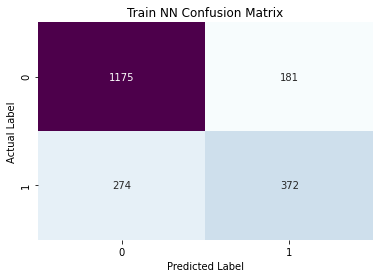

In [ ]:
# Confusion Report and Classification Matrix to check model performance
print(classification_report(y_train, nn_ytrain_pred))

print("      ")
print("________________________________________________________")

print("           ")
sns.heatmap(confusion_matrix(y_train, nn_ytrain_pred),annot=True, fmt='d', cbar=False,cmap='BuPu')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Train NN Confusion Matrix')
plt.show()

Train NN AUC 0.80


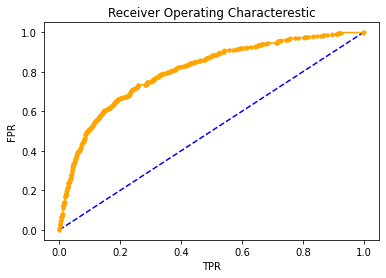

In [ ]:
#AUC NN Train
nn_train_auc = roc_auc_score(y_train, nn_ytrain_pred_prob[:,1])
print("Train NN AUC %.2f" % nn_train_auc)

#ROC
fpr_nn_tr, tpr_nn_tr, th_nn_tr = roc_curve(y_train, nn_ytrain_pred_prob[:,1], pos_label= 1)
plt.plot ([0,1],[0,1], linestyle = '--', color = 'blue', label = 'Unskilled')
plt.plot(fpr_nn_tr, tpr_nn_tr, marker = '.', color = 'orange', label = 'Skill')
plt.ylabel('FPR')
plt.xlabel('TPR')
plt.title('Receiver Operating Characterestic')
plt.show()

##### Neural Network - Test

In [ ]:
# Performance Scores - Test
NN_test_AS = accuracy_score(y_test, nn_ytest_pred, normalize = True)*100
NN_test_PS = precision_score(y_test, nn_ytest_pred)*100
NN_test_F1 = f1_score(y_test, nn_ytest_pred)*100
NN_test_RS = recall_score(y_test, nn_ytest_pred)*100

print('The Test NN Accuracy Score is %.2f'%NN_test_AS,'%')
print('The Test NN Precision Score is %.2f'%NN_test_PS,'%')
print('The Test NN F1 Score is %.2f'%NN_test_F1,'%')
print('The Test NN Recall Score is %.2f'%NN_test_RS,'%')

The Test NN Accuracy Score is 77.18 %
The Test NN Precision Score is 64.75 %
The Test NN F1 Score is 61.72 %
The Test NN Recall Score is 58.96 %


              precision    recall  f1-score   support

           0       0.82      0.85      0.84       591
           1       0.65      0.59      0.62       268

    accuracy                           0.77       859
   macro avg       0.73      0.72      0.73       859
weighted avg       0.77      0.77      0.77       859

      
________________________________________________________
           


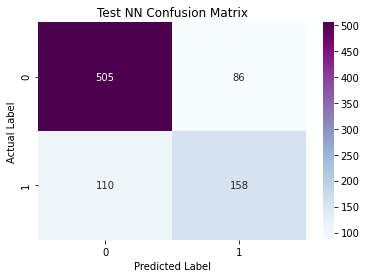

In [ ]:
# Confusion Report and Classification Matrix to check model performance
print(classification_report(y_test, nn_ytest_pred))
print("      ")
print("________________________________________________________")
print("           ")
sns.heatmap(confusion_matrix(y_test, nn_ytest_pred), annot = True, fmt ='d', cmap = 'BuPu' )
#sns.heatmap(confusion_matrix(y_train, nn_y_train_pred),annot=True, fmt='d', cbar=False,cmap='BuPu')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Test NN Confusion Matrix')
plt.show()

Test NN AUC 0.80


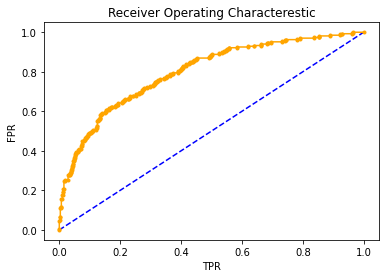

In [ ]:
#AUC - NN TEST
nn_test_auc = roc_auc_score(y_test, nn_ytest_pred_prob[:,1])
print("Test NN AUC %.2f" % nn_test_auc)

#ROC - NN TEST
fpr_nn_t, tpr_nn_t, th_nn_t = roc_curve(y_test, nn_ytest_pred_prob[:,1], pos_label= 1)
plt.plot ([0,1],[0,1], linestyle = '--', color = 'blue', label = 'Unskilled')
plt.plot(fpr_nn_t, tpr_nn_t, marker = '.', color = 'orange', label = 'Skill')
plt.ylabel('FPR')
plt.xlabel('TPR')
plt.title('Receiver Operating Characterestic')
plt.show()

#### Neural Network - GridSearch

In [ ]:
# Define the hyperparameters
parameters = {'solver': ['lbfgs','adam', 'sdg'], 
              'max_iter': [800, 950], 
              'hidden_layer_sizes': np.arange(4,11),
              'activation': ['relu', 'logistic', 'tanh', 'identity'],
              'tol': [0.001, 0.0001],
              'learning_rate': ['constant', 'adaptive']}

In [ ]:
# Train the model, then fit it with training data
import time
start_time = time.time()
NN_grid_model = GridSearchCV(MLPClassifier(random_state = 123), parameters, n_jobs=-1, cv=10)
NN_grid_model.fit(X_train, y_train)
print('The Time taken is', (time.time()-start_time))


The Time taken is 1894.4457397460938


In [ ]:
# Measure Model score on train data 
print(NN_grid_model.score(X_train,y_train))

0.7812187812187812


In [ ]:
# Best parameters in GS
NN_grid_model.best_params_

{'activation': 'logistic',
 'hidden_layer_sizes': 8,
 'learning_rate': 'constant',
 'max_iter': 950,
 'solver': 'lbfgs',
 'tol': 0.001}

In [ ]:
# Best parameters in NN Grid Search
NN_grid_model.best_estimator_

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=8, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=950,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=123, shuffle=True, solver='lbfgs',
              tol=0.001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
# Make train and test class predictions based on the model
nngs_ytrain_pred = NN_grid_model.best_estimator_.predict(X_train)
nngs_ytest_pred= NN_grid_model.best_estimator_.predict(X_test)

# Make train and test probability predictions based on the model
nngs_ytrain_pred_prob = NN_grid_model.best_estimator_.predict_proba(X_train)
nngs_ytest_pred_prob = NN_grid_model.best_estimator_.predict_proba(X_test)


In [ ]:
# Performance Scores - Train 
NNGS_train_AS = accuracy_score(y_train, nngs_ytrain_pred, normalize = True)*100
NNGS_train_PS = precision_score(y_train, nngs_ytrain_pred,)*100
NNGS_train_F1 = f1_score(y_train, nngs_ytrain_pred,)*100
NNGS_train_RS = recall_score(y_train, nngs_ytrain_pred,)*100

print('Train NNGS Accuracy Score is %.2f'%NNGS_train_AS,'%')
print('Train NNGS Precision Score is %.2f'%NNGS_train_PS,'%')
print('Train NNGS F1 Score is %.2f'%NNGS_train_F1,'%')
print('Train NNGS Recall Score is %.2f'%NNGS_train_RS,'%')

Train NNGS Accuracy Score is 78.12 %
Train NNGS Precision Score is 68.57 %
Train NNGS F1 Score is 63.68 %
Train NNGS Recall Score is 59.44 %


              precision    recall  f1-score   support

           0       0.82      0.87      0.84      1356
           1       0.69      0.59      0.64       646

    accuracy                           0.78      2002
   macro avg       0.75      0.73      0.74      2002
weighted avg       0.78      0.78      0.78      2002

      
________________________________________________________
           


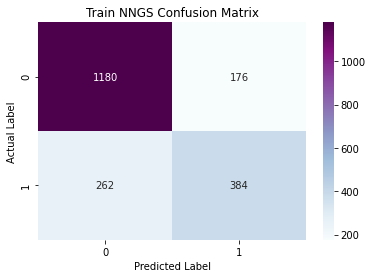

In [ ]:
#Confusion Report and Classification Matrix to check model performance
print(classification_report(y_train, nngs_ytrain_pred))
print("      ")
print("________________________________________________________")
print("           ")
sns.heatmap(confusion_matrix(y_train, nngs_ytrain_pred), annot = True, fmt ='d', cmap = 'BuPu' )
#sns.heatmap(confusion_matrix(y_train, nn_y_train_pred),annot=True, fmt='d', cbar=False,cmap='BuPu')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Train NNGS Confusion Matrix')
plt.show()

Train NNGS AUC Score: 0.80


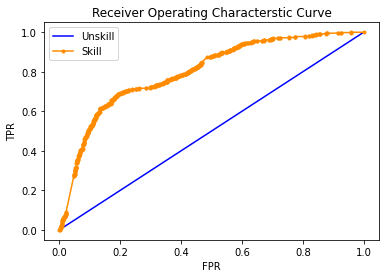

In [ ]:

# ROC and AUC - NN GRID Train
nngs_train_auc = roc_auc_score(y_train, nngs_ytrain_pred_prob[:,1])
print('Train NNGS AUC Score: %.2f' % nngs_train_auc)

fpr_nngs_tr, tpr_nngs_tr, th_nngs_tr = roc_curve(y_train, nngs_ytrain_pred_prob[:,1], pos_label = 1)
plt.plot([0,1], [0,1], linestyle = '-', label = 'Unskill', color = 'blue')
plt.plot(fpr_nngs_tr, tpr_nngs_tr, marker = '.', color = 'darkorange', label = "Skill")
plt.xlabel ("FPR")
plt.ylabel ("TPR")
plt.title ("Receiver Operating Characterstic Curve")
plt.legend()
plt.show()

In [ ]:
# Performance Scores - Test
NNGS_test_AS = accuracy_score(y_test, nngs_ytest_pred, normalize = True)*100
NNGS_test_PS = precision_score(y_test, nngs_ytest_pred)*100
NNGS_test_F1 = f1_score(y_test, nngs_ytest_pred)*100
NNGS_test_RS = recall_score(y_test, nngs_ytest_pred)*100

print('Test NNGS Accuracy Score is %.2f'%NNGS_test_AS,'%')
print('Test NNGS Precision Score is %.2f'%NNGS_test_PS,'%')
print('Test NNGS F1 Score is %.2f'%NNGS_test_F1,'%')
print('Test NNGS Recall Score is %.2f'%NNGS_test_RS,'%')

Test NNGS Accuracy Score is 78.35 %
Test NNGS Precision Score is 67.23 %
Test NNGS F1 Score is 63.24 %
Test NNGS Recall Score is 59.70 %


              precision    recall  f1-score   support

           0       0.83      0.87      0.85       591
           1       0.67      0.60      0.63       268

    accuracy                           0.78       859
   macro avg       0.75      0.73      0.74       859
weighted avg       0.78      0.78      0.78       859

      
________________________________________________________
           


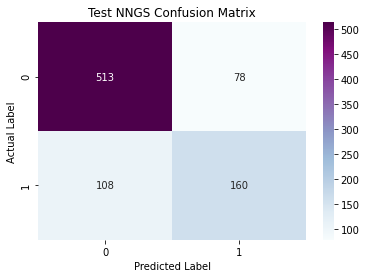

In [ ]:
#Confusion Report and Classification Matrix to check model performance
print(classification_report(y_test, nngs_ytest_pred))
print("      ")
print("________________________________________________________")
print("           ")
sns.heatmap(confusion_matrix(y_test, nngs_ytest_pred), annot = True, fmt ='d', cmap = 'BuPu' )
#sns.heatmap(confusion_matrix(y_train, nn_y_train_pred),annot=True, fmt='d', cbar=False,cmap='BuPu')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Test NNGS Confusion Matrix')
plt.show()

Test NNGS AUC Score: 0.78


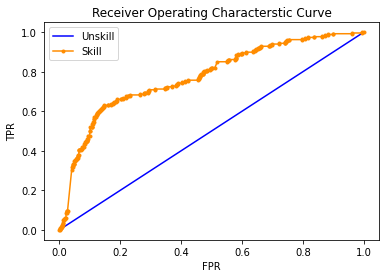

In [ ]:
# AUC NN GRID TEST 
nngs_test_auc = roc_auc_score(y_test, nngs_ytest_pred_prob[:,1])
print('Test NNGS AUC Score: %.2f' % nngs_test_auc)


# ROC NN GRID TEST
fpr_nngs_t, tpr_nngs_t, th_nngs_t = roc_curve(y_test, nngs_ytest_pred_prob[:,1], pos_label = 1)
plt.plot([0,1], [0,1], linestyle = '-', label = 'Unskill', color = 'blue')
plt.plot(fpr_nngs_t, tpr_nngs_t, marker = '.', color = 'darkorange', label = "Skill")
plt.xlabel ("FPR")
plt.ylabel ("TPR")
plt.title ("Receiver Operating Characterstic Curve")
plt.legend()
plt.show()



### **4. Final Model: Compare all the model and write an inference which model is best/optimized.**

In [ ]:
index=['Accuracy', 'AUC', 'Recall','Precision','F1 Score']
data =pd.DataFrame({'DT Train':[CART_train_AS, dt_train_auc, CART_train_RS, CART_train_PS, CART_train_F1],
                    'DT Test':[CART_test_AS, dt_test_auc, CART_test_RS, CART_test_PS, CART_test_F1],
                   'DTGS Train':[DTGS_train_AS, dtgs_train_auc, CART_train_RS, DTGS_train_PS, DTGS_train_F1],
                   'DTGS Test':[CART_test_AS, dtgs_test_auc, CART_test_RS, CART_test_PS, CART_test_F1],
                   'RF Train':[RF_train_AS, rf_train_auc, RF_train_RS, RF_train_PS, RF_train_F1],
                   'RF Test':[RF_test_AS, rf_test_auc, RF_test_RS, RF_test_PS, RF_test_F1],
                   'RFGS Train':[RFGS_train_AS, rfgs_train_auc, RFGS_train_RS, RFGS_train_PS, RFGS_train_F1],
                   'RFGS Test':[RFGS_test_AS, rfgs_test_auc, RFGS_test_RS, RFGS_test_PS, RFGS_test_F1],
                   'NN Train':[NN_train_AS, nn_train_auc, NN_train_RS, NN_train_PS, NN_train_F1],
                   'NN Test':[NN_test_AS, nn_test_auc, NN_test_RS, NN_test_PS, NN_test_F1],
                   'NNGS Train':[NNGS_train_AS, nngs_train_auc, NNGS_train_RS, NNGS_train_PS, NNGS_train_F1],
                   'NNGS Test':[NNGS_test_AS, nngs_test_auc, NNGS_test_RS, NNGS_test_PS, NNGS_test_F1]}, index=index)
round(data,2)

DT Train  DT Test  DTGS Train  ...  NN Test  NNGS Train  NNGS Test
Accuracy      99.25    69.62       77.57  ...    77.18       77.97      78.70
AUC            1.00     0.65        0.81  ...     0.80        0.83       0.81
Recall        97.68    51.87       97.68  ...    58.96       57.43      59.70
Precision    100.00    51.29       67.07  ...    64.75       69.09      68.09
F1 Score      98.83    51.58       63.29  ...    61.72       62.72      63.62

[5 rows x 12 columns]

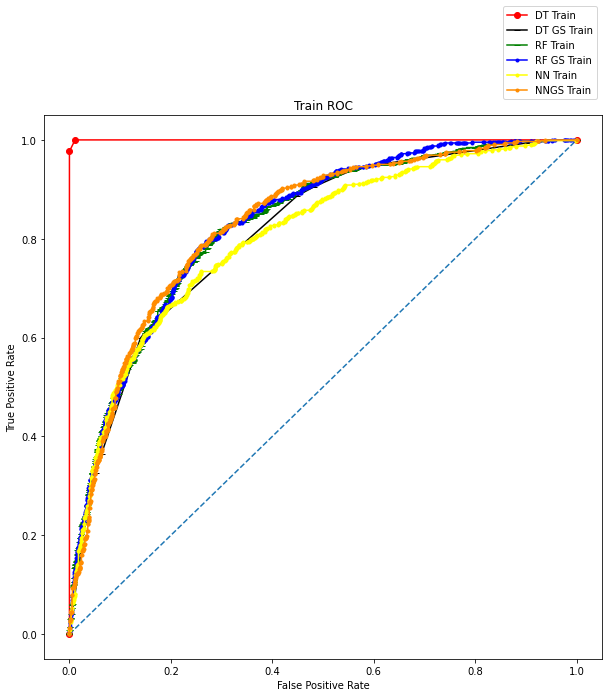

In [ ]:
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_dt_tr,tpr_dt_tr, marker = 'o', color = 'red', label="DT Train")
plt.plot(fpr_dtgs_tr,tpr_dtgs_tr, marker = '_', color = 'k', label = "DT GS Train")
plt.plot(fpr_rf_tr,tpr_rf_tr, marker = '_', color = 'g', label = "RF Train")
plt.plot(fpr_rfgs_tr,tpr_rfgs_tr, marker = '.', color = 'blue', label = "RF GS Train")
plt.plot(fpr_nn_tr, tpr_nn_tr, marker = '.', color = 'yellow',label = "NN Train")
plt.plot(fpr_nngs_tr,tpr_nngs_tr, marker = '.', color = 'darkorange', label = "NNGS Train")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train ROC')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower right')
plt.show()

My prefered model is Random Forest because of a relatively high AUC Score, comparatively high Recall Score and comparatively high F1 Score.


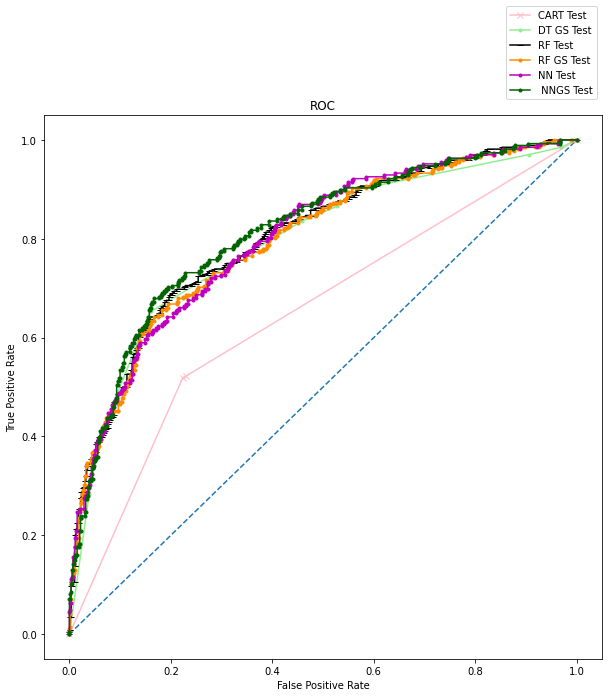

In [ ]:
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], linestyle='--')

plt.plot(fpr_dt_t,tpr_dt_t, marker = 'x', color = 'pink', label="CART Test")
plt.plot(fpr_dtgs_t,tpr_dtgs_t, marker = '.', color = 'lightgreen', label = "DT GS Test")
plt.plot(fpr_rf_t,tpr_rf_t, marker = '_', color = 'k', label = "RF Test")
plt.plot(fpr_rfgs_t, tpr_rfgs_t, marker = '.', color = 'darkorange', label= "RF GS Test")
plt.plot(fpr_nn_t,tpr_nn_t, marker = '.', color = 'm', label = "NN Test")
plt.plot(fpr_nngs_t,tpr_nngs_t, marker = '.', color = 'darkgreen', label = " NNGS Test")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower right')
plt.show()

### **5. Inference: Basis on these predictions, what are the business insights and recommendations**

In [3]:
#Please refer to the Report fr ore information.

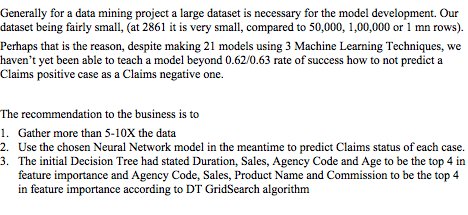